## [MachineLearningMastery](https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/)

## [Forecasting: Principles and Practice](https://otexts.com/fpp2/holt-winters.html)

## Exponential Smoothing for Time Series Forecasting

Exponential Smoothing (ES) is a time series forecasting method for __univariate data__.

Time series methods like the Box-Jenkins ARIMA family of methods develop a model where the prediction is a weighted linear sum of recent past observations or lags.

Exponential smoothing forecasting methods are similar in that a prediction is a __weighted sum of past observations__, but the model explicitly uses an __exponentially decreasing weight for past observations__.

Specifically, past observations are weighted with a __geometrically decreasing ratio__.

Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation, the higher the associated weight.

Exponential smoothing methods may be considered as peers and an __alternative to the popular Box-Jenkins ARIMA class of methods__ for time series forecasting.

Collectively, the methods are sometimes referred to as __ETS models__, referring to the explicit modeling of Error, Trend, and Seasonality.

There are three types of exponential smoothing; they are:

* __Single Exponential Smoothing__, or SES, for univariate data __without trend or seasonality__.
* __Double Exponential Smoothing__ for univariate data with support for __trend__.
* __Triple Exponential Smoothing__, or __Holt-Winters Exponential Smoothing__, with support for both __trend and seasonality__. A triple exponential smoothing model subsumes single and double exponential smoothing by the configuration of the nature of the trend (additive, multiplicative, or none) and the nature of the seasonality (additive, multiplicative, or none), as well as any dampening of the trend.


## Develop a Grid Search Framework

In this section, we will develop a framework for grid searching exponential smoothing model hyperparameters for a given univariate time series forecasting problem.

We will use the implementation of __Holt-Winters Exponential Smoothing__ provided by the statsmodels library.

This model has hyperparameters that control the nature of the exponential performed for the series, trend, and seasonality, specifically:

* __smoothing_level__ $(\alpha)$: the smoothing coefficient for the level.
* __smoothing_slope__ $(\beta)$: the smoothing coefficient for the trend.
* __smoothing_seasonal__ $(\gamma)$: the smoothing coefficient for the seasonal component.
* __damping_slope__ $(\phi)$: the coefficient for the damped trend (Holt-Winters’ damped method)

All four of these hyperparameters can be specified when defining the model. If they are not specified, the library will automatically tune the model and find the optimal values for these hyperparameters (e.g. optimized=True).

There are other hyperparameters that the model will not automatically tune that you may want to specify; they are:

* __trend__: The type of trend component, as either “add” for additive or “mul” for multiplicative. Modeling the trend can be disabled by setting it to None.
* __damped__: Whether or not the trend component should be damped, either True or False.
* __seasonal__: The type of seasonal component, as either “add” for additive or “mul” for multiplicative. Modeling the seasonal component can be disabled by setting it to None.
* _seasonal_periods__: The number of time steps in a seasonal period, e.g. 12 for 12 months in a yearly seasonal structure.
* __use_boxcox__: Whether or not to perform a power transform of the series (True/False) or specify the lambda for the transform.

If you know enough about your problem to specify one or more of these parameters, then you should specify them. If not, you can try grid searching these parameters.

We can start-off by defining a function that will fit a model with a given configuration and make a one-step forecast.

The function takes an array or list of contiguous prior observations and a list of configuration parameters used to configure the model.

The configuration parameters in order are: the trend type, the dampening type, the seasonality type, the seasonal period, whether or not to use a Box-Cox transform, and whether or not to remove the bias when fitting the model.

# Import libraries and define functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import datetime


Bad key "text.kerning_factor" on line 4 in
/Users/joseangelvelasco/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from numpy import array


def exp_smoothing_forecast(history, config):
    """ one-step Holt Winter’s Exponential Smoothing forecast
    """
    t,d,s,p,b,r = config
    # define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]
 

def measure_rmse(actual, predicted):
    """ root mean squared error or rmse
    """
    return sqrt(mean_squared_error(actual, predicted))
 

def train_test_split(data, n_test):
    """ split a univariate dataset into train/test sets
    """
    return data[:-n_test], data[-n_test:]
 
# 
def walk_forward_validation(data, n_test, cfg):
    """ walk-forward validation for univariate data
    """
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error
 
# 
def score_model(data, n_test, cfg, debug=False):
    """ score a model, return None on failure
    """
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# 
def grid_search(data, cfg_list, n_test, parallel=True):
    """ grid search configs
    """
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores
 
# 
def exp_smoothing_configs(seasonal=[None]):
    """ create a set of exponential smoothing configs to try
    """
    models = list()
    # define config lists
    t_params = ['add', 'mul', None] # trend
    d_params = [True, False]        # damped_trend 
    s_params = ['add', 'mul', None] # seasonal
    p_params = seasonal             # season_periods
    b_params = [True, False]        # Box-Cox Transform 
    r_params = [True, False]        # Remove Bias
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models


def mape(y, yhat):
    import numpy as np
    return 100*np.mean(np.abs(y-yhat)/y)

def mae(y, yhat):
    import numpy as np
    return np.mean(np.abs(y-yhat))

def ev(y_hat, y):
    import numpy as np
    return 1- (np.var(y-y_hat)/np.var(y))


def evaluate(y, y_fitted):
    
    from sklearn.metrics import r2_score
    
    R2 = r2_score(y_fitted, y)
    MAPE = mape(y_fitted, y)
    MAE = mae(y_fitted, y)
    EV = ev(y_fitted, y)
    print('R2: {}'.format(R2))
    print('MAPE: {}'.format(MAPE))
    print('MAE: {}'.format(MAE))
    print('EV: {}'.format(EV))
    

def get_model_params(model):
    print('Model Params')
    for param in model_fit.params:
        print('   {}: {}'.format(param, model_fit.params[param]))
    print('Model Params')
    print(model_fit.params_formatted)
    print('Model Stats')
    print('   SSE:{}'.format(model_fit.sse))
    print('   AIC:{}'.format(model_fit.aic))
    print('   BIC:{}'.format(model_fit.bic))
    
def custom_parser(x):
    from datetime import datetime
    return datetime.strptime('195'+x, '%Y-%m')

# 1) Case study with Trend (daily sales)

In [ ]:
# %ls

## 1.1 Load data and visualization 

In [ ]:
# parse dates

 
# load dataset
%cd /Users/joseangelvelasco/Google Drive/datascience/notebooks/Timeseries_forecasting
series = pd.read_csv('shampoo-sales.csv', header=0, index_col=0, date_parser=custom_parser)
data = series.values
y = data.ravel()
ylog = np.log(y)
t = pd.date_range('2019-01-01', '2019-02-05', freq='D')
series = pd.DataFrame(data=y, index=t)
series_log = pd.DataFrame(data=ylog, index=t)

# plot
plt.figure(figsize=(14,4))
plt.plot(series)
plt.title('Time serie', fontsize=14)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(series_log)
plt.title('Log Time serie', fontsize=14)
plt.show()

## 1.2 Seasonal decomposition

In [ ]:
result = seasonal_decompose(series, model='additive')

#plt.figure(figsize=(20,4))
#result.plot()
#plt.show()

series_trend = result.trend
series_seasonal = result.seasonal
series_resid = result.resid
series_observed = result.observed

plt.figure(figsize=(14,4))
plt.plot(series_trend)
plt.title('Trend', fontsize=14)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(series_seasonal)
plt.title('Season', fontsize=14)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(series_resid)
plt.title('Residual', fontsize=14)
plt.show()


## 1.3 Stationarity Analysis

In [ ]:
plot_acf(y, lags=30)
plt.show()

plot_pacf(y, lags=30)
plt.show()

## 1.4 Grid search

In [ ]:
# data split
n_test = 12
# model configs
cfg_list = exp_smoothing_configs()
# grid search
scores = grid_search(y, cfg_list, n_test)
print('done')
# list top 3 configs
print('Trend', 'Damped', 'Seasonal', 'Seasonal Periods', 'Box-Cox Transform', 'Remove Bias', 'RMSE')
for cfg, error in scores[:3]:
    print(cfg, error)

## 1.5 Fit model

In [ ]:
# create class
model = ExponentialSmoothing(y, trend='mul', seasonal='add', seasonal_periods=2)
#model = ExponentialSmoothing(y, trend='mul', seasonal=None)

# fit model
model_fit = model.fit(use_boxcox=False, remove_bias=False)

# print model params
get_model_params(model)

## 1.7 Test prediction

In [ ]:
# make inference
y_fitted = model_fit.predict(0, len(y)-1)

# get regression metrics
evaluate(y, y_fitted)

# plot
plt.figure(figsize=(14,4))
plt.plot(index_time, y_fitted, color='red', label='fit')
plt.scatter(index_time, y, color='blue', label='data', marker='o')
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## 1.8 Forecast

In [ ]:
# make forecast
horizon = 15 #days
yhat = model_fit.forecast(horizon)

t_new = pd.date_range(start = t.max(), periods=horizon, freq='D')
T = np.concatenate((t, t_new))
Y = np.concatenate((y, yhat))
df_new = pd.DataFrame({'T':T, 'Y':Y})

# plot
plt.figure(figsize=(20,8))
y0 = df_new[-horizon*7:]['Y'].values
t0 = df_new[-horizon*7:]['T'].values
plt.plot(t0, y0, color='blue', label='data')
y1 = df_new[-horizon:]['Y'].values
t1 = df_new[-horizon:]['T'].values
plt.plot(t1, y1, color='red', label='prediction')
plt.legend()
plt.show()

# 2) Case Study with Seasonality (monthly temperature)

The ‘monthly mean temperatures’ dataset summarizes the monthly average air temperatures in Nottingham Castle, England from 1920 to 1939 in degrees Fahrenheit.

The dataset has an obvious seasonal component and no obvious trend.

## 2.1 data loading and visualization

In [ ]:
series = pd.read_csv('monthly-mean-temp.csv', header=0, index_col=0)

# trim dataset to 5 years
series = series[-6*12:]
y = series.values.ravel()


t = pd.date_range(pd.to_datetime(series.index.min(), format='%Y-%m'),
                  pd.to_datetime(series.index.max(), format='%Y-%m') + datetime.timedelta(days=30),
                freq='M')

T = pd.DataFrame({'T':t})
T['T'] = T['T'].map(lambda x: x.strftime('%Y-%m'))

t = T.values.ravel()

series_ = pd.DataFrame(data=y, index=t)

print(series_.head())

# plot
plt.figure(figsize=(14,4))
plt.plot(series_)
plt.title('Time serie', fontsize=14)
plt.show()


## 2.2 Sesonal decomposition

In [ ]:
result = seasonal_decompose(series_, model='additive') # multiplicative, additive

#plt.figure(figsize=(20,4))
#result.plot()
#plt.show()

series_trend = result.trend
series_seasonal = result.seasonal
series_resid = result.resid
series_observed = result.observed

plt.figure(figsize=(14,4))
plt.plot(series_trend)
plt.title('Trend', fontsize=14)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(series_seasonal)
plt.title('Season', fontsize=14)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(series_resid)
plt.title('Residual', fontsize=14)
plt.show()



## 2.3 Stationarity analysis

In [ ]:
plot_acf(series_, lags=50)
plt.show()

plot_pacf(series_, lags=50)
plt.show()

## 2.4 Grid search

In [ ]:
# The period of the seasonal component is about one year, or 12 observations.
# model configs
cfg_list = exp_smoothing_configs(seasonal=[0, 12])

# data split
n_test = 12
# model configs
cfg_list = exp_smoothing_configs(seasonal=[0,12])
# grid search
scores = grid_search(y, cfg_list, n_test)
print('done')
# list top 3 configs
print('Trend', 'Damped', 'Seasonal', 'Seasonal Periods', 'Box-Cox Transform', 'Remove Bias', 'RMSE')
for cfg, error in scores[:3]:
    print(cfg, error)

## 2.5 fit model

In [ ]:
# create class
model = ExponentialSmoothing(y, trend='add', seasonal='mul', seasonal_periods=12)

# fit model
model_fit = model.fit(use_boxcox=True, remove_bias=True)

# print model params
get_model_params(model)

## 2.6 test prediction

In [ ]:
# make inference
y_fitted = model_fit.predict(0, len(y)-1)

# get regression metrics
evaluate(y, y_fitted)

# plot
plt.figure(figsize=(14,4))
plt.plot(series.index, y_fitted, color='red', label='fit')
plt.scatter(series.index, y, color='blue', label='data', marker='o')
plt.ylabel('Temperature', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## 2.7 Forecast

In [ ]:
# make forecast
horizon = 48 # months
yhat = model_fit.forecast(horizon)

t_new = pd.date_range(pd.to_datetime(t.max()),
                      pd.to_datetime(t.max()) + datetime.timedelta(days=(horizon+1)*30), freq='M')
T = pd.DataFrame({'T':t_new})
T['T'] = T['T'].map(lambda x: x.strftime('%Y-%m'))     
T = np.concatenate((t, T.values.ravel()))
Y = np.concatenate((y, yhat))
df_new = pd.DataFrame({'T':T, 'Y':Y})

# plot
plt.figure(figsize=(20,8))
y0 = df_new[-horizon*4:]['Y'].values
t0 = df_new[-horizon*4:]['T'].values
plt.plot(t0, y0, color='blue', label='data')
y1 = df_new[-horizon:]['Y'].values
t1 = df_new[-horizon:]['T'].values
plt.plot(t1, y1, color='red', label='prediction')
plt.legend()
plt.show()

# 3) Case study with Trend and Seasonality (monthly sales)

## 3.1 Load data and visualization

/Users/joseangelvelasco/Google Drive/datascience/notebooks/Timeseries_forecasting


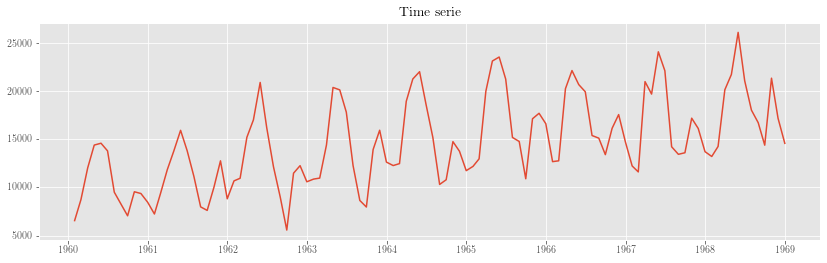

In [3]:
%cd /Users/joseangelvelasco/Google Drive/datascience/notebooks/Timeseries_forecasting
series = pd.read_csv('monthly-car-sales.csv', header=0, index_col=0)

y = series.values.ravel()

t = pd.date_range(pd.to_datetime(series.index.min(), format='%Y-%m'),
                  pd.to_datetime(series.index.max(), format='%Y-%m') + datetime.timedelta(days=30),
                freq='M')

#T = pd.DataFrame({'T':t})
#T['T'] = T['T'].map(lambda x: x.strftime('%Y-%m'))

#t = T.values.ravel()

series = pd.DataFrame(data=y, index=t)

# plot
plt.figure(figsize=(14,4))
plt.plot(series)
plt.title('Time serie', fontsize=14)
plt.show()


## 3.3 seasonal decomposition

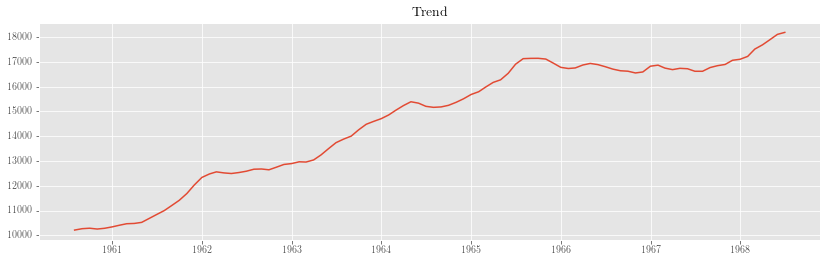

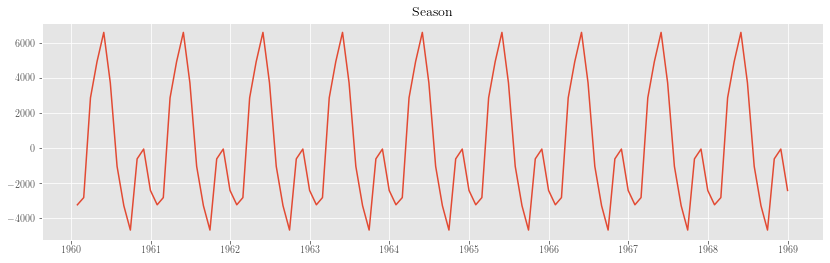

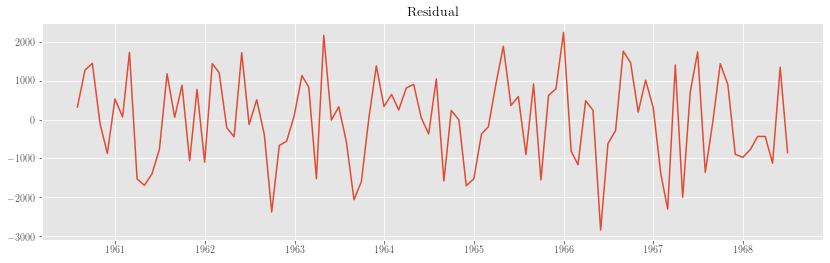

In [4]:
result = seasonal_decompose(series, model='additive') # multiplicative, additive

#plt.figure(figsize=(20,4))
#result.plot()
#plt.show()

series_trend = result.trend
series_seasonal = result.seasonal
series_resid = result.resid
series_observed = result.observed

plt.figure(figsize=(14,4))
plt.plot(series_trend)
plt.title('Trend', fontsize=14)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(series_seasonal)
plt.title('Season', fontsize=14)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(series_resid)
plt.title('Residual', fontsize=14)
plt.show()



## 3.3 Stationarity analysis

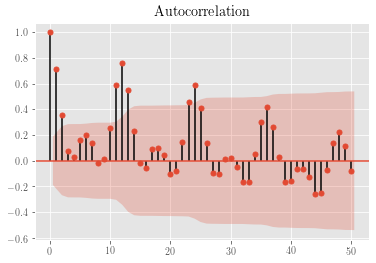

/Users/joseangelvelasco/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


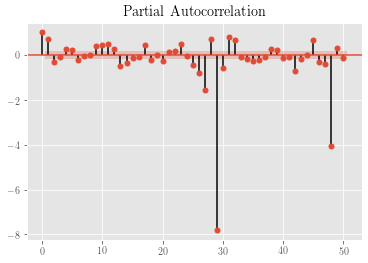

In [5]:
plot_acf(series, lags=50)
plt.show()

plot_pacf(series, lags=50)
plt.show()

## 3.4 grid search

In [10]:
# data split
n_test = 12
# model configs
cfg_list = exp_smoothing_configs(seasonal=[0, 6, 12])
# grid search
scores = grid_search(y, cfg_list, n_test)
print('done')
# list top 3 configs
print('Trend', 'Damped', 'Seasonal', 'Seasonal Periods', 'Box-Cox Transform', 'Remove Bias', 'RMSE')
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[['add', True, 'add', 6, False, False]] 3226.384
 > Model[['add', True, 'add', 6, False, True]] 3240.433
 > Model[['add', True, 'add', 6, True, False]] 2755.843
 > Model[['add', True, 'add', 6, True, True]] 2758.825
 > Model[['add', True, 'add', 12, False, True]] 1748.333
 > Model[['add', True, 'mul', 6, False, True]] 2993.915
 > Model[['add', True, 'mul', 6, True, True]] 2945.238
 > Model[['add', True, 'add', 12, True, True]] 2180.261
 > Model[['add', True, 'add', 12, False, False]] 1725.435
 > Model[['add', True, 'mul', 6, True, False]] 2929.752
 > Model[['add', True, 'mul', 6, False, False]] 2978.513
 > Model[['add', True, 'add', 12, True, False]] 2144.365
 > Model[['add', True, None, 0, True, True]] 3932.712
 > Model[['add', True, None, 0, True, False]] 3913.742
 > Model[['add', True, None, 0, False, True]] 3922.605
 > Model[['add', True, None, 0, False, False]] 3902.931
 > Model[['add', True, None, 6, True, True]] 3932.712
 > Model[['add', True, None, 6, True, False]] 3913

## 3.5 fit model

In [11]:
# create class
model = ExponentialSmoothing(y, trend='add', seasonal='add', seasonal_periods=12)

# fit model
model_fit = model.fit(use_boxcox=False, remove_bias=False)

# print model params
get_model_params(model)

Model Params
   smoothing_level: 0.15253098774241228
   smoothing_slope: 4.921971393547838e-13
   smoothing_seasonal: 0.2809728210516192
   damping_slope: nan
   initial_level: 9694.70508534619
   initial_slope: 64.77178426327234
   initial_seasons: [-3902.50623388 -2159.65207585  1306.80504828  3624.68226508
  4363.97759452  2682.44374652 -1489.55397486 -3452.97604092
 -4691.94334451 -1614.00752032 -1221.189377   -2935.45598856]
   use_boxcox: False
   lamda: None
   remove_bias: False
Model Params
                     name         param  optimized
smoothing_level     alpha  1.525310e-01       True
smoothing_slope      beta  4.921971e-13       True
smoothing_seasonal  gamma  2.809728e-01       True
initial_level         l.0  9.694705e+03       True
initial_slope         b.0  6.477178e+01       True
initial_seasons.0     s.0 -3.902506e+03       True
initial_seasons.1     s.1 -2.159652e+03       True
initial_seasons.2     s.2  1.306805e+03       True
initial_seasons.3     s.3  3.624682e

## 3.5 Test prediction

R2: 0.8834484275732853
MAPE: 8.180365751783595
MAE: 1144.1172163969652
EV: 0.8981858403857823


/Users/joseangelvelasco/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/joseangelvelasco/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


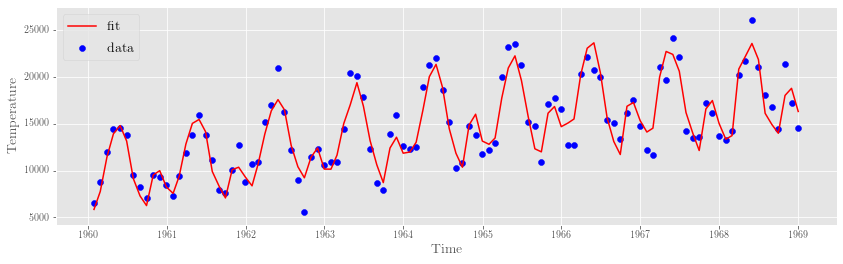

In [12]:
# make inference
y_fitted = model_fit.predict(0, len(y)-1)

# get regression metrics
evaluate(y, y_fitted)

# plot
plt.figure(figsize=(14,4))
plt.plot(series.index, y_fitted, color='red', label='fit')
plt.scatter(series.index, y, color='blue', label='data', marker='o')
plt.ylabel('Temperature', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## 3.6 Forecast

In [54]:
len(T)

112

In [55]:
# make forecast
horizon = 3 # months
yhat = model_fit.forecast(horizon)

t_new = pd.date_range(pd.to_datetime(t.max()),
                      pd.to_datetime(t.max()) + datetime.timedelta(days=(horizon)*30), freq='M')
T = pd.DataFrame({'T':t_new})
#T['T'] = T['T'].map(lambda x: x.strftime('%Y-%m'))     
T = np.concatenate((t, T.values.ravel()))
Y = np.concatenate((y, yhat))
df_new = pd.DataFrame({'T':T, 'Y':Y})

# plot
plt.figure(figsize=(20,8))
y0 = df_new[-horizon*4:]['Y'].values
t0 = df_new[-horizon*4:]['T'].values
plt.plot(t0, y0, color='blue', label='data')
y1 = df_new[-horizon:]['Y'].values
t1 = df_new[-horizon:]['T'].values
plt.plot(t1, y1, color='red', label='prediction')
plt.legend()
plt.show()

ValueError: arrays must all be same length

# 4) Case Study real data REE data (hourly electrical demand)

## 4.1 load data and visualization

In [ ]:
%cd '/Volumes/HDD/data/ree/profiles'
series = pd.read_csv('REE_data_processed.csv', usecols=['timestamp', 'coef_a_smooth'])
#series = series.loc[-24*15:,:]
#series['timestamp'] = pd.to_datetime(series['timestamp'])

y = series['coef_a_smooth'].values
t = series['timestamp'].values

#series.set_index(['timestamp'], inplace=True, drop=True)

print(series.head())
print(series.tail())

# plot
plt.figure(figsize=(14,4))
plt.plot(t, y)
plt.show()

# plot
#plt.figure(figsize=(14,4))
#plt.plot(t[-24*15:],y[-24*15:])
#plt.show()


## 4.2 Seasonal descomposition

In [ ]:
result = seasonal_decompose(series, model='additive') # multiplicative, additive

#plt.figure(figsize=(20,4))
#result.plot()
#plt.show()

series_trend = result.trend
series_seasonal = result.seasonal
series_resid = result.resid
series_observed = result.observed

plt.figure(figsize=(14,4))
plt.plot(series_trend)
plt.title('Trend', fontsize=14)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(series_seasonal)
plt.title('Season', fontsize=14)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(series_resid)
plt.title('Residual', fontsize=14)
plt.show()

## 4.3 Stationarity analysis

In [ ]:
plot_acf(series, lags=50)
plt.show()

plot_pacf(series, lags=50)
plt.show()

## 4.4 Grid search

### Grid search

In [ ]:
# data split
n_test = 4
# model configs
cfg_list = exp_smoothing_configs()
# grid search
scores = grid_search(y, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error) 

We can see that the best result was an RMSE of about 0.12 births with the following configuration:

* Trend: None
* Damped: False
* Seasonal: None
* Seasonal Periods: None
* Box-Cox Transform: True
* Remove Bias: True

https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html?highlight=exponentialsmoothing#statsmodels.tsa.holtwinters.ExponentialSmoothing

## 4.5 Fit model

In [ ]:
# create class

#model = ExponentialSmoothing(y, trend=None, seasonal_periods=None, seasonal=None)
model = ExponentialSmoothing(y, trend='add', seasonal='add', seasonal_periods=24)

# fit model
model_fit = model.fit()

print('Params:', model_fit.params)
print('SSE:{}'.format(model_fit.sse))
print('AIC:{}'.format(model_fit.aic))
print('BIC:{}'.format(model_fit.bic))
# print(model_fit.level)
print(model_fit.params_formatted)

## 4.6 test prediction

In [ ]:
# make inference
y_fitted = model_fit.predict(0, len(y)-1)
from sklearn.metrics import r2_score

R2 = r2_score(y_fitted, y)
MAPE = mape(y_fitted, y)
MAE = mae(y_fitted, y)
EV = ev(y_fitted, y)
print('R2: {}'.format(R2))
print('MAPE: {}'.format(MAPE))
print('MAE: {}'.format(MAE))
print('EV: {}'.format(EV))

In [ ]:
# make forecast
horizon = 48
yhat = model_fit.forecast(horizon)
print('Forecast')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)

In [ ]:
t_new = pd.date_range(start = t.max(), periods=horizon, freq='H')
T = np.concatenate((t, t_new))
Y = np.concatenate((y, yhat))
df_new = pd.DataFrame({'T':T, 'Y':Y})

# plot
plt.figure(figsize=(20,8))
y0 = df_new[-horizon*7:]['Y'].values
t0 = df_new[-horizon*7:]['T'].values
plt.plot(t0, y0, color='blue', label='data')
y1 = df_new[-horizon:]['Y'].values
t1 = df_new[-horizon:]['T'].values
plt.plot(t1, y1, color='red', label='prediction')
plt.legend()
plt.show()